
# TCI 2020-2021 Analysis

Data anomalies detection and smoothing of daily data serie.


### References:

- [Awesome TS anomaly detection](https://github.com/rob-med/awesome-TS-anomaly-detection#:~:text=Anomaly%20Detection%20Toolkit%20(ADTK)%20is,based%20time%20series%20anomaly%20detection.&text=AnomalyDetection%20is%20an%20open%2Dsource,seasonality%20and%20an%20underlying%20trend)
- [ADTK library](https://github.com/arundo/adtk)
- [ADTK examples](https://adtk.readthedocs.io/en/stable/examples.html)
- [PyOD library](https://pyod.readthedocs.io/en/latest/)
- [Prophet Facebook](https://github.com/facebook/prophet)

In [3]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Loading data

In [4]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

In [5]:
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where country_iso_code = 'MX'
""", conn)

In [6]:
df.head()

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,5,15,5,3502110,14987382.0,0.233671,-76.632944,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-05-15
1,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,7,3,5,5023556,14987382.0,0.335186,-66.481431,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-07-03
2,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,6,19,5,5100711,14987382.0,0.340334,-65.966631,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-06-19
3,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,7,17,5,7625905,14987382.0,0.508822,-49.117831,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-07-17
4,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,9,4,5,7560016,14987382.0,0.504425,-49.557461,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-09-04


In [7]:
# df['date'] = pd.to_datetime(df[['year','month','day']].astype(str).apply(' '.join, 1), format='%Y %m %d')
df['datetime'] = df['date'].astype(str).apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [8]:
# Time range
print(min(df.date))
print(max(df.date))
df.describe()

2020-03-09 00:00:00
2021-03-01 00:00:00


,year,month,day,dow,observed,expected_2020,ratio_20,tcp
count,4296.000000,4296.000000,4296.000000,4296.000000,4.296000e+03,4.296000e+03,4296.000000,4296.000000
mean,2020.167598,6.594972,15.930168,3.991620,5.139079e+07,5.924030e+07,0.837522,-16.247793
std,0.373552,3.446016,8.748445,2.003704,1.370920e+08,1.207538e+08,0.670063,67.006271
min,2020.000000,1.000000,1.000000,1.000000,1.299180e+05,6.317860e+05,0.079478,-92.052232
25%,2020.000000,4.000000,9.000000,2.000000,2.528666e+06,4.199193e+06,0.396226,-60.377450
50%,2020.000000,7.000000,16.000000,4.000000,5.712060e+06,1.103633e+07,0.694369,-30.563136
75%,2020.000000,10.000000,23.000000,6.000000,1.837422e+07,3.278052e+07,1.007442,0.744212
max,2021.000000,12.000000,31.000000,7.000000,1.252923e+09,5.187512e+08,7.468349,646.834889


In [9]:
# Equivale a athena spd_sdv_waze_corona.prod_daily_daily_index
#df = pd.read_csv('~/shared/spd-sdv-omitnik-waze/corona/prod/private/daily/write_index/write_index_daily.csv', sep = "|")
#df = df[df.month != 'TRUE']
#print(df.shape)

# Exploratory analysis

In [10]:
print(df.shape)
df.columns

(4296, 21)


Index(['last_updated_utc', 'region_slug', 'region_name', 'country_name',
       'country_iso_code', 'country_idb_code', 'region_type', 'population',
       'timezone', 'year', 'month', 'day', 'dow', 'observed', 'expected_2020',
       'ratio_20', 'tcp', 'dashboard', 'region_shapefile_wkt', 'date',
       'datetime'],
      dtype='object')

In [11]:
print(len(df['region_slug'].unique()))
df['country_name'].unique()

12


array(['Mexico'], dtype=object)


Days observed per region_slug

In [12]:
df \
  .siu_group_by('region_slug', "country_name") \
  .siu_summarize(nc = _.tcp.count(),
                 tcp = _.tcp.mean(),
                 tcp_min = _.tcp.min(),
                 tcp_max = _.tcp.max(),
                 dat_min = _.date.min(),
                 dat_max = _.date.max()
                 ) \
  .siu_ungroup()

,region_slug,country_name,nc,tcp,tcp_min,tcp_max,dat_min,dat_max
0,aguascalientes,Mexico,358,-18.203266,-89.772846,295.093715,2020-03-09,2021-03-01
1,country_mexico,Mexico,358,5.913793,-83.873186,236.146628,2020-03-09,2021-03-01
2,guadalajara,Mexico,358,-32.480785,-88.839614,101.185662,2020-03-09,2021-03-01
3,leon,Mexico,358,-13.417957,-90.705502,171.461936,2020-03-09,2021-03-01
4,merida,Mexico,358,-44.218855,-85.996939,69.881371,2020-03-09,2021-03-01
5,mexicocity,Mexico,358,-39.119472,-92.052232,80.020119,2020-03-09,2021-03-01
6,monterrey,Mexico,358,-42.198185,-89.642462,234.132600,2020-03-09,2021-03-01
7,pueble,Mexico,358,-28.826548,-81.048294,90.490344,2020-03-09,2021-03-01
8,queretaro,Mexico,358,-43.837401,-89.328917,105.990360,2020-03-09,2021-03-01
9,sanluispotosi,Mexico,358,-6.237598,-91.638874,457.361712,2020-03-09,2021-03-01


TCI observations per date 

In [18]:
tab = df \
      .siu_group_by('region_slug', "country_name", "date") \
      .siu_summarize(nc = _.tcp.count(),
                     tcp = _.tcp.mean(),
                     tcp_min = _.tcp.min(),
                     tcp_max = _.tcp.max()
                     ) \
      .siu_ungroup()
tab.head()

,region_slug,country_name,date,nc,tcp,tcp_min,tcp_max
0,aguascalientes,Mexico,2020-03-09,1,-42.103947,-42.103947,-42.103947
1,aguascalientes,Mexico,2020-03-10,1,3.740975,3.740975,3.740975
2,aguascalientes,Mexico,2020-03-11,1,8.477060,8.477060,8.477060
3,aguascalientes,Mexico,2020-03-12,1,13.016856,13.016856,13.016856
4,aguascalientes,Mexico,2020-03-13,1,-6.457111,-6.457111,-6.457111


In [19]:
print(tab.shape)
tab.siu_filter(_.nc > 1).shape

(4296, 7)


(0, 7)

In [20]:
#tab.siu_filter(_.nc > 1).head()

# Feature creation

### TCI time serie per region

In [21]:
df.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date,datetime
0,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,5,15,5,3502110,14987382.0,0.233671,-76.632944,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-05-15,2020-05-15
1,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,7,3,5,5023556,14987382.0,0.335186,-66.481431,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-07-03,2020-07-03
2,2021-03-02 11:37:42.704,queretaro,Querétaro,Mexico,MX,ME,city,991669,America/Mexico_City,2020,6,19,5,5100711,14987382.0,0.340334,-65.966631,TRUE,Polygon ((-100.45874824020972937 20.7579188795...,2020-06-19,2020-06-19


In [22]:
df_sel = (df
 >> select('date', 'dow', 'year', 'month',
           'region_slug', 'tcp',
           'observed', 'expected_2020', 'ratio_20', 'population')
 >> arrange(_.region_slug, _.date)
 >> mutate(observed_log = _.observed)
 >> group_by('region_slug')
 >> mutate(observed_1day = _.observed.shift(1),
           observed_7day = _.observed.shift(7))
 >> ungroup()
 >> group_by('region_slug', 'dow')    
 >> mutate(observed_1dow = _.observed.shift(1))          
 >> ungroup()          
 >> mutate(diff_1day = _.observed - _.observed_1day,
           diff_7day = _.observed - _.observed_7day)  
 >> ungroup()  
)

In [23]:
df_sel.head(8)

,date,dow,year,month,region_slug,tcp,observed,expected_2020,ratio_20,population,observed_log,observed_1day,observed_7day,observed_1dow,diff_1day,diff_7day
0,2020-03-09,1,2020,3,aguascalientes,-42.103947,1263784,2182850.0,0.578961,911397,1263784,NaN,NaN,NaN,NaN,NaN
1,2020-03-10,2,2020,3,aguascalientes,3.740975,2865805,2762462.0,1.037410,911397,2865805,1263784.0,NaN,NaN,1602021.0,NaN
2,2020-03-11,3,2020,3,aguascalientes,8.477060,3073397,2833223.0,1.084771,911397,3073397,2865805.0,NaN,NaN,207592.0,NaN
3,2020-03-12,4,2020,3,aguascalientes,13.016856,3009640,2663001.0,1.130169,911397,3009640,3073397.0,NaN,NaN,-63757.0,NaN
4,2020-03-13,5,2020,3,aguascalientes,-6.457111,3196426,3417070.0,0.935429,911397,3196426,3009640.0,NaN,NaN,186786.0,NaN
5,2020-03-14,6,2020,3,aguascalientes,14.228133,3623811,3172433.0,1.142281,911397,3623811,3196426.0,NaN,NaN,427385.0,NaN
6,2020-03-15,7,2020,3,aguascalientes,-5.568909,1381338,1462800.0,0.944311,911397,1381338,3623811.0,NaN,NaN,-2242473.0,NaN
7,2020-03-16,1,2020,3,aguascalientes,-56.431179,951042,2182850.0,0.435688,911397,951042,1381338.0,1263784.0,1263784.0,-430296.0,-312742.0


## Plots 

Plot of TCI per region

In [24]:
df_sel[['date', 'observed', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='observed') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI observed',
)

In [25]:
df_sel[['date', 'diff_1day', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='diff_1day') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI difference one day',
)

In [26]:
df_sel[['date', 'diff_7day', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='diff_7day') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI difference seven day',
)

In [132]:
#(ggplot(df_sel,
#        aes('date', 'tcp', color='factor(region_slug)'))
# + geom_line()
# + geom_point()
# + theme(axis_text_x=element_text(angle=90)))

## Day of week observations

Observed TCI series per day of week

In [27]:
df_dow = (df_sel
 >> select( 'region_slug', 'date',  'dow', 'observed') 
 >> mutate( aux_var = (_.dow == 1))
 >> group_by('region_slug')
 >> mutate( week = _.aux_var.cumsum())
 >> ungroup()
 >> group_by('region_slug', 'week')
 >> mutate( min_date = _.date.min())
 >> ungroup()
 >> select( 'region_slug', 'dow', 'min_date', 'observed') 
).dropna()
df_dow['log_observed'] = np.log(df_dow['observed'])

In [28]:
print(min(df_dow.min_date))
print(max(df_dow.min_date))
df_dow.head()

2020-03-09 00:00:00
2021-03-01 00:00:00


,region_slug,dow,min_date,observed,log_observed
0,aguascalientes,1,2020-03-09,1263784,14.049621
1,aguascalientes,2,2020-03-09,2865805,14.868360
2,aguascalientes,3,2020-03-09,3073397,14.938294
3,aguascalientes,4,2020-03-09,3009640,14.917331
4,aguascalientes,5,2020-03-09,3196426,14.977544


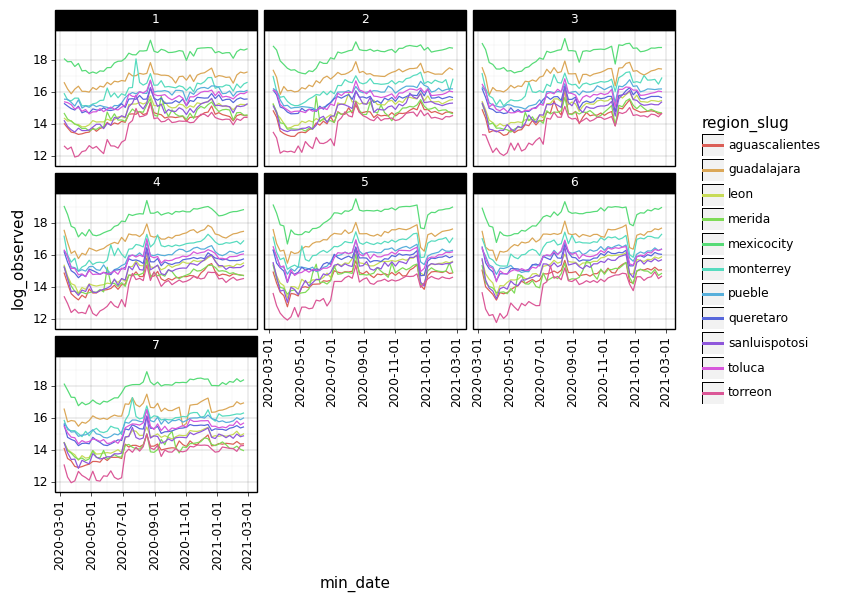

<ggplot: (8793807397177)>

In [35]:
(p9.ggplot(data=df_dow.siu_filter(_.region_slug!='country_mexico'),
           mapping=p9.aes(x='min_date', y='log_observed', color = 'region_slug')) 
    + p9.geom_line() 
    + p9.facet_wrap('dow') 
    + p9.theme(figure_size = (8, 6),
                axis_text_x=p9.element_text(angle=90))
)

# Outliers detection

### Test-Train set

In [130]:
# train sample
y_train = df_sel.siu_filter(_.region_slug == 'country_mexico') \
    .siu_arrange('date') \
    .siu_select('date', 'observed') \
    .set_index('date')
print(y_train.shape)
x_train = df_sel.siu_filter(_.region_slug == 'country_mexico') \
    .siu_arrange('date') \
    .siu_select('date', 'observed_7day', 'observed_1day') \
    .set_index('date')
print(x_train.shape)

(358, 1)
(358, 2)


In [131]:
# Split train y test
# x_train, y_train, x_test, y_test = generate_data(n_train=200, n_test=100, n_features=2)


### Univariate with ADTK

In [132]:
from adtk.data import validate_series
from adtk.visualization import plot

             observed
date                 
2020-03-09  19.231987
2020-03-10  19.782542
2020-03-11  19.921604
2020-03-12  19.952954
2020-03-13  20.065398


[<AxesSubplot:>]

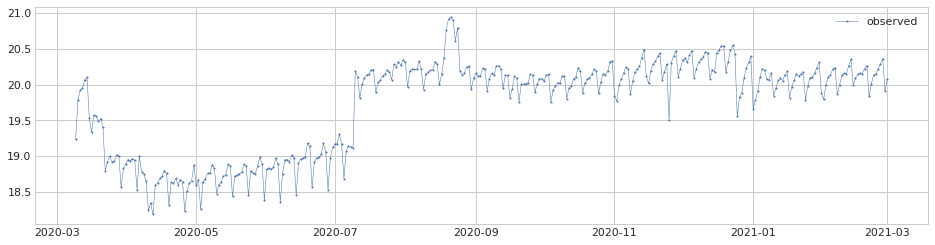

In [133]:
s_train = validate_series(np.log(y_train))
print(s_train.head())
plot(s_train)

[<AxesSubplot:>]

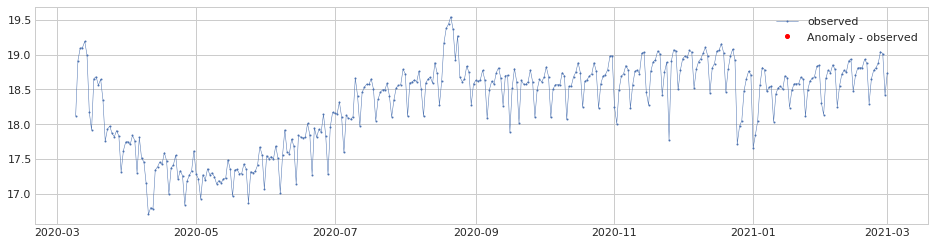

In [41]:
# SeasonalAD detects anomalous violations of seasonal pattern.
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD()
anomalies = seasonal_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

[<AxesSubplot:>]

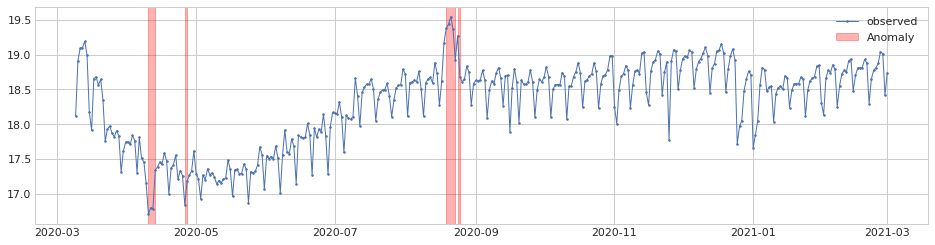

In [42]:
# OutlierDetector performs multivariate time-independent outlier 
# detection and identifies outliers as anomalies. 
# The multivariate outlier detection algorithm could be those in 
# scikit-learn or other packages following same API.
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.025))
anomalies = outlier_detector.fit_detect(s_train)
plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')


In [134]:
# ClassicSeasonalDecomposition decomposes a series into trend part (optional), 
# seasonal part and residual part. The residual part may help identifying 
# anomalous deviation from seasonal pattern.

# QuantileAD compares each time series value with historical quantiles. 
# In the following example, we detect time points when temperature is 
# above 99% percentile or below 1% percentile.
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition
quantile_ad = QuantileAD(high=0.98, low=0.01)
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.98, low=0.01))
]
pipeline = Pipeline(steps)

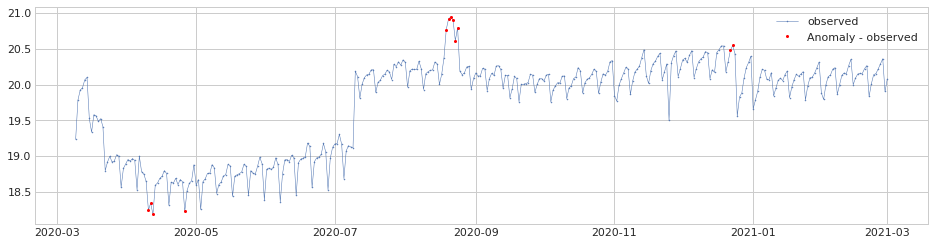

In [135]:
s = validate_series(s_train)
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');
anomalies_pipe = anomalies

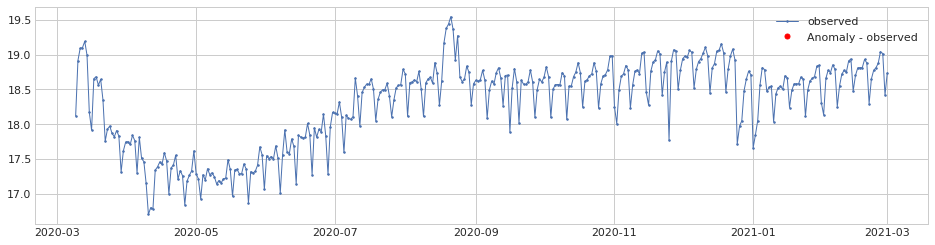

In [45]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s_train)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [46]:
#from adtk.data import split_train_test
#splits = split_train_test(s, mode=2, n_splits=3)
#df = pd.DataFrame(index=s.index)
#for i, (train, test) in enumerate(splits):
#    df["train_{}".format(i)] = train
#    df["test_{}".format(i)] = test
#plot(df, 
#     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
#     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
#     figsize=(16, 8));

In [47]:
#y_train_pred

### Multivariate with PyOD

In [50]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [51]:
x_train_sp = x_train.dropna()
print(x_train_sp.shape)
y_train_sp = y_train[y_train.index.isin(x_train.index)]
print(y_train_sp.shape)

(351, 2)
(358, 1)


In [52]:
clf = ABOD(method="fast") # initialize detector
clf.fit(x_train_sp)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [53]:
y_train_pred = clf.predict(x_train_sp) # binary labels
y_train_scores = clf.decision_function(x_train_sp) # raw outlier scores
y_train_proba = clf.predict_proba(x_train_sp) # outlier probability

#evaluate_print("ABOD", y_train, y_train_scores) # performance evaluation
#ABOD Performance; ROC: 0.934; Precision at n: 0.902

In [54]:
#evaluate_print("ABOD", y_train, y_train_scores) # performance evaluation
# visualize(y_train_sp, y_train_pred)


# Imputation 

Following missing values

In [136]:
df_sel.head()
anomalies_pipe.head()

df_miss = full_join(y_train, 
          anomalies_pipe.siu_rename(outlier_label = "observed"), on = "date") \
        .siu_mutate(missing = _.observed[_.outlier_label == False]) \
        .siu_ungroup()
print(df_miss.shape)
print(y_train.shape)
print(sum(df_miss.outlier_label))
df_miss.head()

(358, 3)
(358, 1)
12


,observed,outlier_label,missing
date,,,
2020-03-09,225084722,False,225084722.0
2020-03-10,390345217,False,390345217.0
2020-03-11,448583065,False,448583065.0
2020-03-12,462868620,False,462868620.0
2020-03-13,517954693,False,517954693.0


### Interpolation by time
Works on daily and higher resolution data to interpolate given length of interval.

In [56]:
df_miss['predict'] = np.exp(np.log(df_miss.missing+1).interpolate(method='time',  inplace=False))
df_miss.siu_filter(_.outlier_label)

,observed,outlier_label,missing,predict
date,,,,
2020-03-11,195417551,True,NaN,1.795755e+08
2020-04-09,28089455,True,NaN,3.236154e+07
2020-04-10,17988090,True,NaN,2.730983e+07
2020-04-11,19817430,True,NaN,2.304671e+07
2020-05-12,28281968,True,NaN,2.961634e+07
2020-08-18,211217862,True,NaN,1.229416e+08
2020-08-19,259895936,True,NaN,1.238406e+08
2020-08-20,275977842,True,NaN,1.247461e+08
2020-08-21,306857480,True,NaN,1.256583e+08


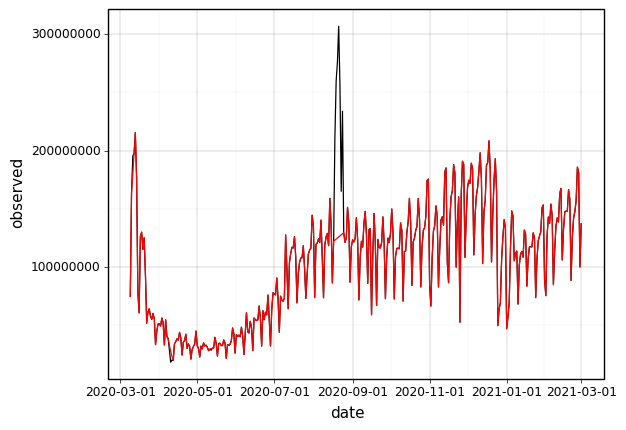

<ggplot: (8793780763781)>

In [58]:
(p9.ggplot(data=df_miss.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
    + p9.geom_line() 
    + p9.geom_line(p9.aes(y='predict'), color='red'))

### Rolling average

Movig average per day of week

In [59]:
df_miss['mov_avg'] = df_miss['observed'].rolling(7).mean()

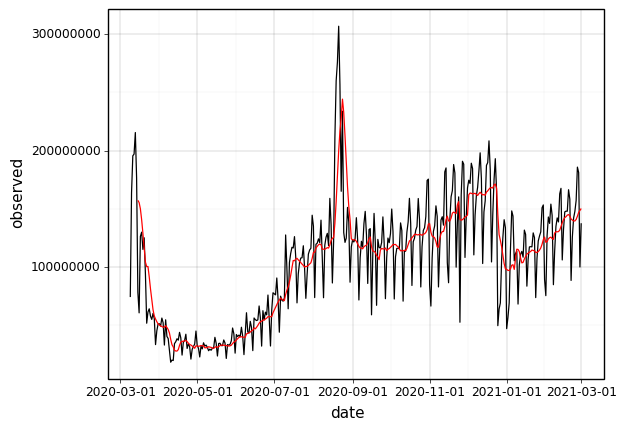

<ggplot: (8793780902221)>

In [60]:
(p9.ggplot(data=df_miss.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
    + p9.geom_line() 
    + p9.geom_line(p9.aes(y='mov_avg'), color='red'))

### Seasonal decomposition

In [80]:
#help(plotly.offline.plot)
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

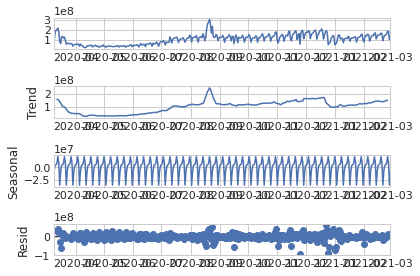

In [81]:
result = seasonal_decompose(y_train, model='additive')
fig = result.plot()
#plot_mpl(fig)

### Arima model


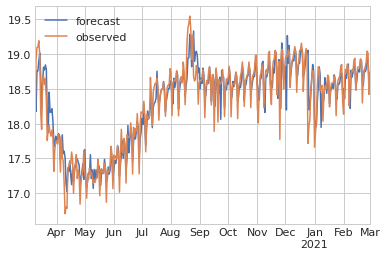

In [63]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA( np.log(df_miss.observed), (7, 0, 1))
fit = model.fit()
fig = fit.plot_predict()
# print(fit.summary())

<AxesSubplot:>

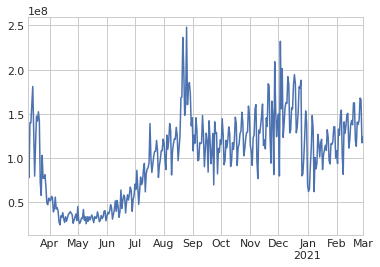

In [64]:
# fitted values
fitted_values = fit.predict(start=-len(df_miss.index))
np.exp(fitted_values).plot()

In [65]:
#fit.forecast(len(df_miss.index))[0]

### Lowess Smoother

Lowess smoothing daily data

In [69]:
from tsmoothie.smoother import LowessSmoother

# operate smoothing
smoother = LowessSmoother(smooth_fraction=.05, iterations=1)
smoother.smooth(np.log(df_miss.observed))

# generate intervals
low, up = smoother.get_intervals('prediction_interval')
#smoother.smooth_data

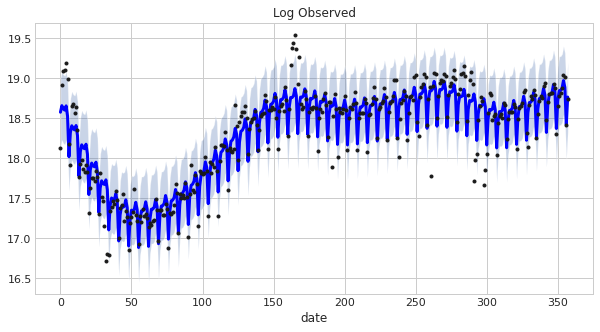

In [75]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(10,5))
#plt.subplot(1,3,i+1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.title("Log Observed")
plt.xlabel('date')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

### Lowess Smoother

Lowess smoothing daily data

In [137]:
from tsmoothie.smoother import DecomposeSmoother

# operate smoothing
smoother = DecomposeSmoother(smooth_type='lowess', periods=7,
                             smooth_fraction=0.2)
smoother.smooth(np.log(df_miss.observed))

# generate intervals
low, up = smoother.get_intervals('sigma_interval')

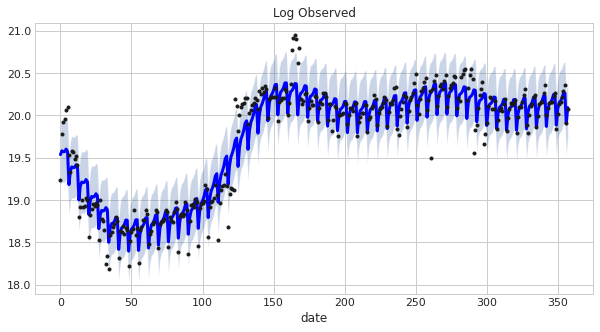

In [138]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(10,5))
#plt.subplot(1,3,i+1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.title("Log Observed")
plt.xlabel('date')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

In [139]:
df_miss['lowess_fit'] = np.exp(smoother.smooth_data[0])

In [140]:
df_miss['imputation'] = df_miss['observed']
df_miss['imputation'][df_miss['outlier_label']] = df_miss['lowess_fit'][df_miss['outlier_label']]
df_miss.head()

,observed,outlier_label,missing,lowess_fit,imputation
date,,,,,
2020-03-09,225084722,False,225084722.0,3.045576e+08,225084722.0
2020-03-10,390345217,False,390345217.0,3.185737e+08,390345217.0
2020-03-11,448583065,False,448583065.0,3.150175e+08,448583065.0
2020-03-12,462868620,False,462868620.0,3.158719e+08,462868620.0
2020-03-13,517954693,False,517954693.0,3.251545e+08,517954693.0


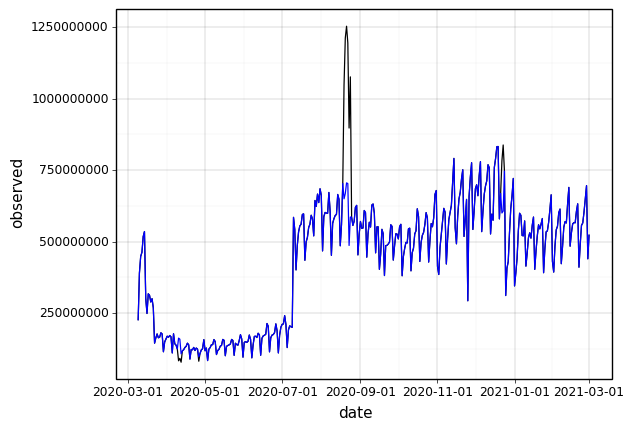

<ggplot: (8793778387145)>

In [141]:
(p9.ggplot(data=df_miss.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
    + p9.geom_line() 
    + p9.geom_line(p9.aes(y='imputation'), color='blue'))

# Day of week 

In [89]:
df_dow.siu_filter(_.dow==1).head()

,region_slug,dow,min_date,observed,log_observed
0,aguascalientes,1,2020-03-09,1263784,14.049621
7,aguascalientes,1,2020-03-16,951042,13.765314
14,aguascalientes,1,2020-03-23,730408,13.501359
21,aguascalientes,1,2020-03-30,696030,13.453148
28,aguascalientes,1,2020-04-06,632119,13.356833


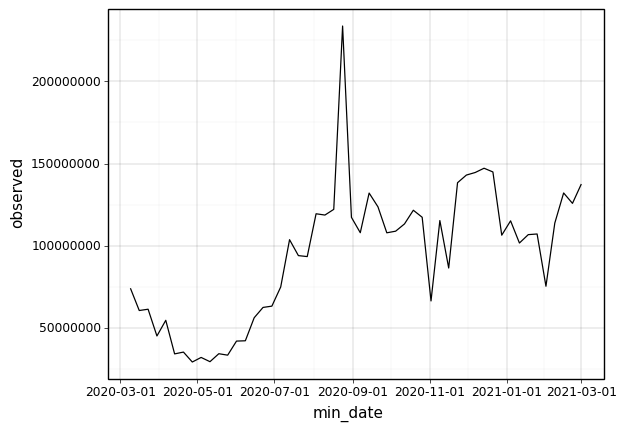

<ggplot: (8793807113781)>

In [108]:
df_dow_mx = df_dow.siu_filter(_.dow==1, _.region_slug == 'mexicocity')
(p9.ggplot(data=df_dow_mx,
           mapping=p9.aes(x='min_date', y='observed')) 
    + p9.geom_line() )

            observed
min_date            
2020-03-09  74001430
2020-03-16  60411449
2020-03-23  61202267
2020-03-30  44890808
2020-04-06  54440222


[<AxesSubplot:>]

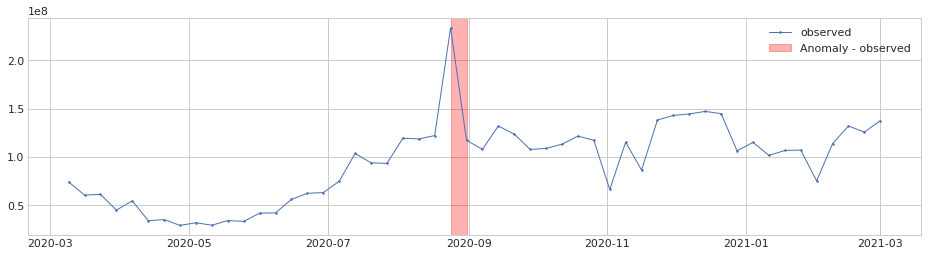

In [113]:
y_dow = df_dow_mx \
    .siu_arrange('min_date') \
    .siu_select('min_date', 'observed') \
    .set_index('min_date')

s_dow = validate_series(y_dow)
print(s_dow.head())
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies_dow = iqr_ad.fit_detect(s_dow)
plot(s_dow, anomaly=anomalies_dow, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')


In [114]:
df_miss_dow = full_join(y_dow, 
          anomalies_dow.siu_rename(outlier_label = "observed"), on = "min_date") \
        .siu_mutate(missing = _.observed[_.outlier_label == False]) \
        .siu_ungroup()
print(df_miss_dow.shape)
print(y_dow.shape)
print(sum(df_miss_dow.outlier_label))
df_miss_dow.head()

(52, 3)
(52, 1)
1


,observed,outlier_label,missing
min_date,,,
2020-03-09,74001430,False,74001430.0
2020-03-16,60411449,False,60411449.0
2020-03-23,61202267,False,61202267.0
2020-03-30,44890808,False,44890808.0
2020-04-06,54440222,False,54440222.0


In [123]:
from tsmoothie.smoother import LowessSmoother

# operate smoothing
smoother = LowessSmoother(smooth_fraction=.05, iterations=1)
smoother.smooth(np.log(df_miss_dow.observed))

# generate intervals
low, up = smoother.get_intervals('prediction_interval')
#smoother.smooth_data

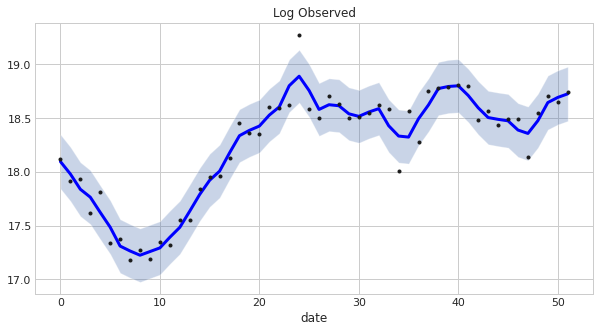

In [124]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(10,5))
#plt.subplot(1,3,i+1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.title("Log Observed")
plt.xlabel('date')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

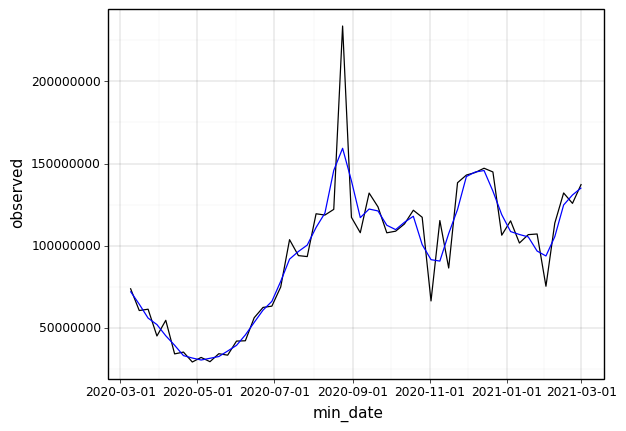

<ggplot: (8793807184997)>

In [129]:
df_miss_dow['smooothed'] = np.exp(smoother.smooth_data[0])
(p9.ggplot(data=df_miss_dow.reset_index(),
           mapping=p9.aes(x='min_date', y='observed')) 
    + p9.geom_line() 
    + p9.geom_line(p9.aes(y='smooothed'), color='blue'))